# Swiss Covid-19 Data Analysis

### Import and Basic Config

In [65]:
import pandas as pd
import altair as alt
import matplotlib.pyplot as plt
import matplotlib, matplotlib.colors
import cycler
import mplcyberpunk
plt.style.use("cyberpunk")

data_url = 'https://raw.githubusercontent.com/openZH/covid_19/master/COVID19_Fallzahlen_CH_total_v2.csv'

### Helper Functions

In [66]:
def pivot_variable(df, values):
    return df.pivot(columns='abbreviation_canton_and_fl', values=values).ffill().fillna(0)

def total_average(df):
    return df.sum(axis=1).rolling(7, center=True).mean()

def plot(df, ax, **kwargs):
        
    df.plot.line(xlabel='', ax=ax, **kwargs)

    ax.set_title('Schweiz (7-Tage Mittel)', fontsize=18)

    lines = ax.get_lines()
    axes = [ax]
    if hasattr(ax, 'right_ax'):
        axes.append(ax.right_ax)
        right_lines = ax.right_ax.get_lines()
        for l in right_lines:
            l.set_label(l.get_label() + ' (rechts)')
        lines += right_lines
        ax.right_ax.grid(False)

    ax.legend(lines, [l.get_label() for l in lines], loc='upper center', ncol=3, prop={'size': 14})

    for a in axes:
        a.tick_params(axis='both', labelsize=14)
        mplcyberpunk.add_glow_effects(a)

    ax.grid(axis='both')

### Load Data and Drop Unused Columns and Liechtenstein

In [78]:
data = pd.read_csv(data_url, parse_dates=['date'])
data = data.drop(columns=['time', 'source']).set_index(['date'])
data = data.set_index('abbreviation_canton_and_fl', append=True).drop('FL', level=1).reset_index(level=1)

### Extract Variables of Interest and Pivot by Canton

In [43]:
ncumul_conf = pivot_variable(data, 'ncumul_conf')
current_hosp = pivot_variable(data, 'current_hosp')
ncumul_deceased = pivot_variable(data, 'ncumul_deceased')
new_hosp = pivot_variable(data, 'new_hosp')

### Build Dataframes of Interesting Swiss Totals

The daily new confirmed cases are calculated from the cumulative variable by taking the differences. The total hospitalization is the cumulative sum of the daily new hospitalizations.

In [29]:
df_daily = pd.concat([
    total_average(ncumul_conf.diff()).rename('Neu bestätigt'),
    total_average(current_hosp).rename('Aktuell hospitalisiert'),
    total_average(ncumul_deceased.diff()).rename('Neu verstorben'),
], axis=1)

df_cumul = pd.concat([
    total_average(ncumul_conf).rename('Total bestätigt'),
    total_average(new_hosp.cumsum()).rename('Total hospitalisiert'),
    total_average(ncumul_deceased).rename('Total verstorben'),
], axis=1)

### Create the Plot

Cyberpunk style...

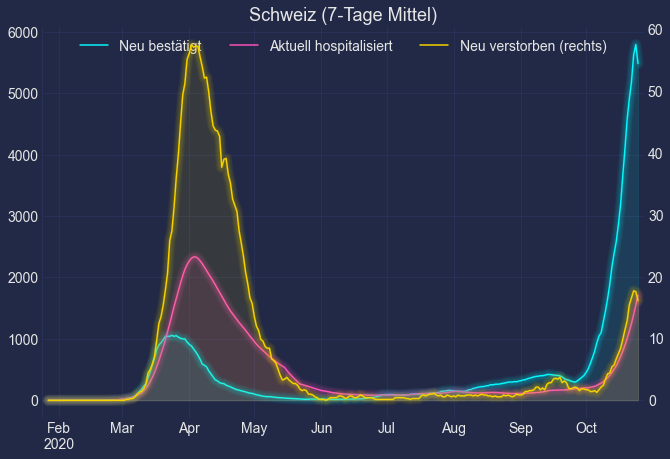

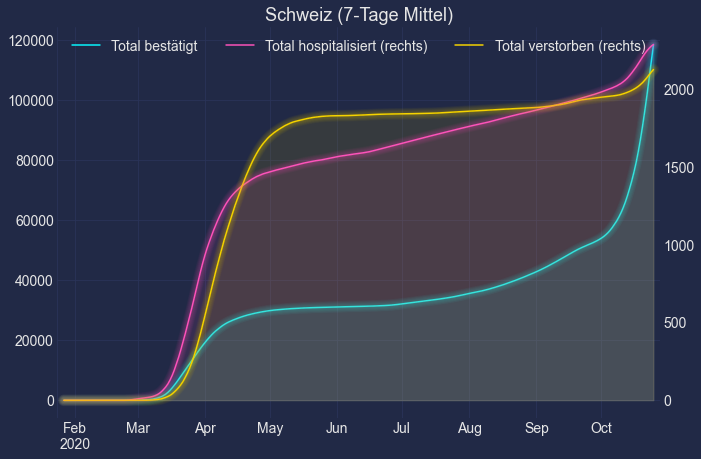

In [31]:
plt.close('all')

plt.figure()
ax = plt.subplot(1, 1, 1)
ax.figure.set_size_inches((1.8*6, 1.8*4))
plot(df_daily, ax, secondary_y=['Neu verstorben',], logy=False)

plt.figure()
ax = plt.subplot(1, 1, 1)
ax.figure.set_size_inches((1.8*6, 1.8*4))
plot(df_cumul, ax, secondary_y=['Total hospitalisiert', 'Total verstorben',])

In [95]:
import altair as alt
alt.data_transformers.enable('data_server')

DataTransformerRegistry.enable('data_server')

In [15]:
def mark_line_glow(base, y, label):
    glow_base = base.encode(y=y, color=alt.Color(label))
    line = base.encode(y=y, color=alt.Color(label))
    glow = glow_base.mark_area(opacity=0.1)
    
    n_lines = 10
    diff_linewidth = 1.25
    alpha_value = 0.3 / n_lines
    for n in range(n_lines):
        line_width = 5 + (diff_linewidth * n)
        glow += glow_base.mark_line(opacity=alpha_value,
                                size=line_width)
    line = line.mark_line()

    return line + glow

base = alt.Chart(
    data_url
).transform_impute(
    impute='max',
    key='date',
    frame=[-1, -1],
    groupby=['abbreviation_canton_and_fl'],
).transform_window(
    sort=[{'field': 'date'}],
    frame=[-6, 0],
    groupby=['abbreviation_canton_and_fl'],
    ncumul_conf_mean='mean(ncumul_conf)',
    ncumul_deceased_mean='mean(ncumul_deceased)',
).transform_window(
    sort=[{'field': 'date'}],
    frame=[None, 0],
    groupby=['abbreviation_canton_and_fl'],
    ncumul_hosp='sum(new_hosp)',
).transform_calculate(
    conf_label='"confirmed"',
    deceased_label='"deceased"',
    hosp_label='"hospitalized"',
    day='day(datum.date)',
).encode(
    #alt.X('date:T')
    alt.X(
        'yearmonthdate(date):O',
        axis=alt.Axis(
            labelExpr="day(datum.value) == 1 ? timeFormat(datum.value, '%Y-%m-%d W %W') : ''",
            grid=True,
            gridColor=alt.condition('day(datum.value) == 1', alt.value('#2A3459'), alt.value(None))
        )
    )
    #alt.X('date:T', timeUnit='week')
)

conf = mark_line_glow(
    base,
    alt.Y('sum(ncumul_conf_mean):Q', axis=alt.Axis(title='Confirmed')),
    'conf_label:N'
)
deceased = mark_line_glow(
    base,
    alt.Y('sum(ncumul_deceased_mean):Q', axis=alt.Axis(title='Hospitalized, Deceased')),
    'deceased_label:N'
)
hosp = mark_line_glow(
    base,
    alt.Y('sum(ncumul_hosp):Q', axis=alt.Axis(title='Hospitalized, Deceased')),
    'hosp_label:N'
)

alt.layer(
    conf,
    hosp + deceased
).resolve_legend(
    color='independent',
).resolve_scale(
    y='independent'
).configure_range(
    category=['#08F7FE', '#FE53BB', '#F5D300', '#00ff41', 'r', '#9467bd'],
).configure_axis(
    title=None,
    ticks=False,
    domain=False,
    gridColor='#2A3459',
    labelColor='#D3D3D3',
    labelFontSize=14,
    labelPadding=10,
    labelSeparation=40,
    titleColor='#D3D3D3',
    titleFontSize=14,
).configure_legend(
    title=None,
    labelColor='#D3D3D3',
    labelFontSize=14,
    orient='top-left',
    symbolType='stroke',
    symbolStrokeWidth=3,
    symbolSize=600
).configure_view(
    strokeWidth=0
).properties(
    background='#212946',
    width=1.2*600,
    height=1.2*350
)

alt.LayerChart(...)

alt.LayerChart(...)

In [30]:
import altair as alt
from vega_datasets import data

source = data.movies.url

heatmap = alt.Chart(source).mark_rect().encode(
    alt.X('IMDB_Rating:Q', bin=True),
    alt.Y('Rotten_Tomatoes_Rating:Q', bin=True),
    alt.Color('count()', scale=alt.Scale(scheme='greenblue'))
)

points = alt.Chart(source).mark_circle(
    color='black',
    size=5,
).encode(
    x='IMDB_Rating:Q',
    y='Rotten_Tomatoes_Rating:Q',
)

heatmap + points

alt.LayerChart(...)

In [32]:
pd.read_json(source)

,Title,US Gross,Worldwide Gross,US DVD Sales,Production Budget,Release Date,MPAA Rating,Running Time min,Distributor,Source,Major Genre,Creative Type,Director,Rotten Tomatoes Rating,IMDB Rating,IMDB Votes
0,The Land Girls,146083.0,146083.0,NaN,8000000.0,Jun 12 1998,R,NaN,Gramercy,None,None,None,None,NaN,6.1,1071.0
1,"First Love, Last Rites",10876.0,10876.0,NaN,300000.0,Aug 07 1998,R,NaN,Strand,None,Drama,None,None,NaN,6.9,207.0
2,I Married a Strange Person,203134.0,203134.0,NaN,250000.0,Aug 28 1998,None,NaN,Lionsgate,None,Comedy,None,None,NaN,6.8,865.0
3,Let's Talk About Sex,373615.0,373615.0,NaN,300000.0,Sep 11 1998,None,NaN,Fine Line,None,Comedy,None,None,13.0,NaN,NaN
4,Slam,1009819.0,1087521.0,NaN,1000000.0,Oct 09 1998,R,NaN,Trimark,Original Screenplay,Drama,Contemporary Fiction,None,62.0,3.4,165.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3196,Zack and Miri Make a Porno,31452765.0,36851125.0,21240321.0,24000000.0,Oct 31 2008,R,101.0,Weinstein Co.,Original Screenplay,Comedy,Contemporary Fiction,Kevin Smith,65.0,7.0,55687.0
3197,Zodiac,33080084.0,83080084.0,20983030.0,85000000.0,Mar 02 2007,R,157.0,Paramount Pictures,Based on Book/Short Story,Thriller/Suspense,Dramatization,David Fincher,89.0,NaN,NaN
3198,Zoom,11989328.0,12506188.0,6679409.0,35000000.0,Aug 11 2006,PG,NaN,Sony Pictures,Based on Comic/Graphic Novel,Adventure,Super Hero,Peter Hewitt,3.0,3.4,7424.0
3199,The Legend of Zorro,45575336.0,141475336.0,NaN,80000000.0,Oct 28 2005,PG,129.0,Sony Pictures,Remake,Adventure,Historical Fiction,Martin Campbell,26.0,5.7,21161.0


In [40]:
cmap

In [43]:
cmap(0, bytes=True)

(0, 255, 255, 255)

In [56]:
cmap(3/3, bytes=True)

(255, 0, 255, 255)

In [54]:
cmap?

Signature:      cmap(X, alpha=None, bytes=False)
Type:           LinearSegmentedColormap
String form:    <matplotlib.colors.LinearSegmentedColormap object at 0x00000164064480A0>
File:           c:\users\michael.wild\projects\covid\.venv\lib\site-packages\matplotlib\colors.py
Docstring:     
Colormap objects based on lookup tables using linear segments.

The lookup table is generated using linear interpolation for each
primary color, with the 0-1 domain divided into any number of
segments.
Init docstring:
Create color map from linear mapping segments

segmentdata argument is a dictionary with a red, green and blue
entries. Each entry should be a list of *x*, *y0*, *y1* tuples,
forming rows in a table. Entries for alpha are optional.

Example: suppose you want red to increase from 0 to 1 over
the bottom half, green to do the same over the middle half,
and blue over the top half.  Then you would use::

    cdict = {'red':   [(0.0,  0.0, 0.0),
                       (0.5,  1.0, 1.0),
     

In [59]:
cmap.N

256

In [83]:
colors = plt.rcParams['axes.prop_cycle']

In [74]:
colors.simplify()

'#08F7FE'
'#FE53BB'
'#F5D300'
'#00ff41'
'r'
'#9467bd'


In [76]:
c = cycler.cycler([1,2,3])

TypeError: If only one positional argument given, it must  be a Cycler instance.

In [78]:
i = iter(cycler.cycler('colors', [1,2,3]))

In [82]:
next(i)

StopIteration: 

In [125]:
import altair as alt
from vega_datasets import data

stockdata = data.stocks()
stockdata['pe'] = stockdata['price'] / 10

selector = alt.selection_single(
    fields=['symbol'], 
    empty='all',
    init={'symbol': 'AAPL'},
    bind='legend'
)

base = alt.Chart(stockdata)

price = base.mark_line(point=True).encode(
    x='date:T',
    y='price:Q',
    color='symbol:N',
    opacity=alt.condition(selector, alt.value(1), alt.value(0))
).add_selection(
    selector
)

pe = base.mark_bar().encode(
    x='date:T',
    y='pe:Q',
    color='symbol:N'
).transform_filter(
    selector
)

price + pe

alt.LayerChart(...)

In [7]:
base = alt.Chart(
    data_url
).transform_impute(
    impute='value',
    value=None,
    key='date',
    frame=[-1, -1],
    groupby=['abbreviation_canton_and_fl'],
).transform_window(
    ncumul_conf_mean='mean(ncumul_conf)',
    ncumul_deceased_mean='mean(ncumul_deceased)',

    sort=[{'field': 'date'}],
    frame=[-6, 0],
    groupby=['abbreviation_canton_and_fl'],
).transform_window(
    ncumul_hosp='sum(new_hosp)',
    
    sort=[{'field': 'date'}],
    frame=[None, 0],
    groupby=['abbreviation_canton_and_fl'],
).transform_aggregate(
    confirmed='sum(ncumul_conf_mean)',
    deceased='sum(ncumul_deceased_mean)',
    hospitalized='sum(ncumul_hosp)',
    
    groupby=['date'],
).transform_fold(
    as_=['foo', 'value'],

    fold=['confirmed', 'deceased', 'hospitalized'],
).encode(
    x=alt.X('date:T'),
    color='foo:N'
)

n_lines = 10
diff_linewidth = 1.25
alpha_value = 0.3 / n_lines

#line = base.mark_line(
#    opacity=alpha_value,
#    size=diff_linewidth,
#)
#for n in range(1, n_lines):
#    line_width = 5 + (diff_linewidth * n)
#    line += base.mark_line(
#        opacity=alpha_value,
#        size=line_width,
#    )
line = base.mark_line()
#line += base.mark_area(opacity=0.1)

confirmed = line.transform_filter(
    alt.datum.foo == 'confirmed',
).encode(
    y=alt.Y('value:Q', axis=alt.Axis(title='Confirmed')),
)

others = line.transform_filter(
    alt.datum.foo != 'confirmed',
).encode(
    y=alt.Y('value:Q', axis=alt.Axis(title='Hospitalized, Deceased')),
)

alt.layer(
    confirmed,
    others,
).resolve_scale(
    y='independent'
).configure_range(
    category=['#08F7FE', '#FE53BB', '#F5D300', '#00ff41', 'r', '#9467bd'],
).configure_axis(
    title=None,
    ticks=False,
    domain=False,
    gridColor='#2A3459',
    labelColor='#D3D3D3',
    titleColor='#D3D3D3',
    titleFontSize=14,
    labelFontSize=14,
    labelPadding=10,
    labelSeparation=40
).configure_legend(
    labelColor='#D3D3D3',
    labelFontSize=14,
    orient='top-left',
    symbolType='stroke',
    symbolStrokeWidth=3,
    symbolSize=600,
    title=None,
    direction='horizontal',
).configure_view(
    strokeWidth=0
).properties(
    background='#212946',
    width=1.2*600,
    height=1.2*350
)

alt.LayerChart(...)

In [167]:
colors.by_key(_)

['#08F7FE', '#FE53BB', '#F5D300', '#00ff41', 'r', '#9467bd']

In [192]:
type(confirmed)

altair.vegalite.v4.api.LayerChart

In [55]:
base = alt.Chart(
    data_url
).transform_impute(
    impute='max',
    key='date',
    frame=[-1, -1],
    groupby=['abbreviation_canton_and_fl'],
).transform_window(
    sort=[{'field': 'date'}],
    frame=[-6, 0],
    groupby=['abbreviation_canton_and_fl'],
    ncumul_conf_mean='mean(ncumul_conf)',
    ncumul_deceased_mean='mean(ncumul_deceased)',
).transform_window(
    sort=[{'field': 'date'}],
    frame=[None, 0],
    groupby=['abbreviation_canton_and_fl'],
    ncumul_hosp='sum(new_hosp)',
).transform_calculate(
    conf_label='"confirmed"',
    deceased_label='"deceased"',
    hosp_label='"hospitalized"',
    day='day(datum.date)',
).encode(
    x=alt.X('date:T'),
    y=alt.Y('sum(ncumul_conf_mean):Q')
)

base.transform_filter(alt.datum.day == 0).mark_circle(
    size=60,
) + base.mark_line()

alt.LayerChart(...)

In [20]:
data.columns

Index(['abbreviation_canton_and_fl', 'ncumul_tested', 'ncumul_conf',
       'new_hosp', 'current_hosp', 'current_icu', 'current_vent',
       'ncumul_released', 'ncumul_deceased', 'current_isolated',
       'current_quarantined', 'current_quarantined_riskareatravel',
       'current_quarantined_total'],
      dtype='object')

In [54]:
ncumul_conf.melt()

,abbreviation_canton_and_fl,value
0,AG,0.0
1,AG,0.0
2,AG,0.0
3,AG,0.0
4,AG,0.0
...,...,...
7275,ZH,17236.0
7276,ZH,17649.0
7277,ZH,18285.0
7278,ZH,19260.0


In [52]:
data.columns

Index(['abbreviation_canton_and_fl', 'ncumul_tested', 'ncumul_conf',
       'new_hosp', 'current_hosp', 'current_icu', 'current_vent',
       'ncumul_released', 'ncumul_deceased', 'current_isolated',
       'current_quarantined', 'current_quarantined_riskareatravel',
       'current_quarantined_total'],
      dtype='object')

In [112]:
x = data.set_index('abbreviation_canton_and_fl', append=True).groupby(['abbreviation_canton_and_fl']).ffill().fillna(0)
y = x.sum(axis=0, level=0)
y['abbreviation_canton_and_fl'] = 'Total'
df = x.melt(ignore_index=False).reset_index()

In [117]:
alt.Chart(
    df
).encode(
    x='date',
    y='value',
    color='abbreviation_canton_and_fl',
    tooltip=['date', 'abbreviation_canton_and_fl', 'value']
).mark_area(
).facet(
    facet='variable',
    columns=2
).resolve_scale(
    y='independent'
)

alt.FacetChart(...)

<AxesSubplot:xlabel='date'>

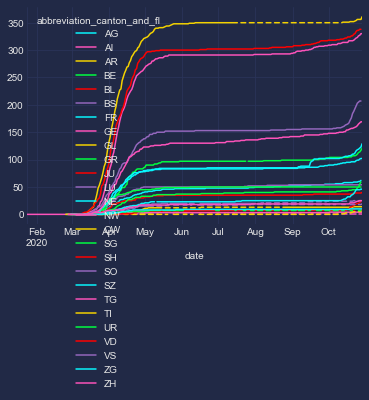

In [160]:
y = x.ncumul_deceased.to_frame().reset_index(level=1)
y.pivot(columns='abbreviation_canton_and_fl', values='ncumul_deceased').plot.line()

In [103]:
pd.DataFrame.pivot()

,ncumul_tested,ncumul_conf,new_hosp,current_hosp,current_icu,current_vent,ncumul_released,ncumul_deceased,current_isolated,current_quarantined,current_quarantined_riskareatravel,current_quarantined_total,abbreviation_canton_and_fl
date,,,,,,,,,,,,,
2020-01-24,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Total
2020-01-25,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Total
2020-01-26,11.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Total
2020-01-27,18.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Total
2020-01-28,27.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Total
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-10-25,76957.0,111216.0,5.0,1566.0,139.0,48.0,10507.0,2074.0,16191.0,21156.0,0.0,0.0,Total
2020-10-26,109475.0,124938.0,5.0,1925.0,175.0,64.0,11118.0,2159.0,19063.0,23033.0,0.0,0.0,Total
2020-10-27,109475.0,131580.0,5.0,2084.0,192.0,69.0,11467.0,2172.0,20656.0,21970.0,0.0,0.0,Total


In [164]:
data.index.unique().shape

(280,)

In [171]:
df = pd.DataFrame(np.nan, index=data.index.unique(), columns=data.columns[1:])

In [172]:
df

,ncumul_tested,ncumul_conf,new_hosp,current_hosp,current_icu,current_vent,ncumul_released,ncumul_deceased,current_isolated,current_quarantined,current_quarantined_riskareatravel,current_quarantined_total
date,,,,,,,,,,,,
2020-01-24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
2020-10-25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-10-26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-10-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
